In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime, timedelta
import math

import yfinance as yf

In [2]:
yf.pdr_override()
stocks_list =['AAPL', 'GOOG', 'TSLA', 'NVDA']

end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL, GOOG, TSLA, NVDA]
company_name = ["APPLE", "GOOGLE", "TESLA", "NVIDA"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-05-13,904.780029,909.979980,885.289978,903.989990,903.989990,28968000,NVIDA
2024-05-14,895.989990,916.510010,889.340027,913.559998,913.559998,29650700,NVIDA
2024-05-15,924.719971,948.619995,915.989990,946.299988,946.299988,41773500,NVIDA
2024-05-16,949.099976,958.190002,941.030029,943.590027,943.590027,32395200,NVIDA
2024-05-17,943.690002,947.400024,918.059998,924.789978,924.789978,35969100,NVIDA
2024-05-20,937.500000,952.000000,934.400024,947.799988,947.799988,31876400,NVIDA
2024-05-21,935.989990,954.000000,931.799988,953.859985,953.859985,32894600,NVIDA
2024-05-22,954.590027,960.200012,932.489990,949.500000,949.500000,54864800,NVIDA
2024-05-23,1020.280029,1063.199951,1015.200012,1037.989990,1037.989990,83506500,NVIDA


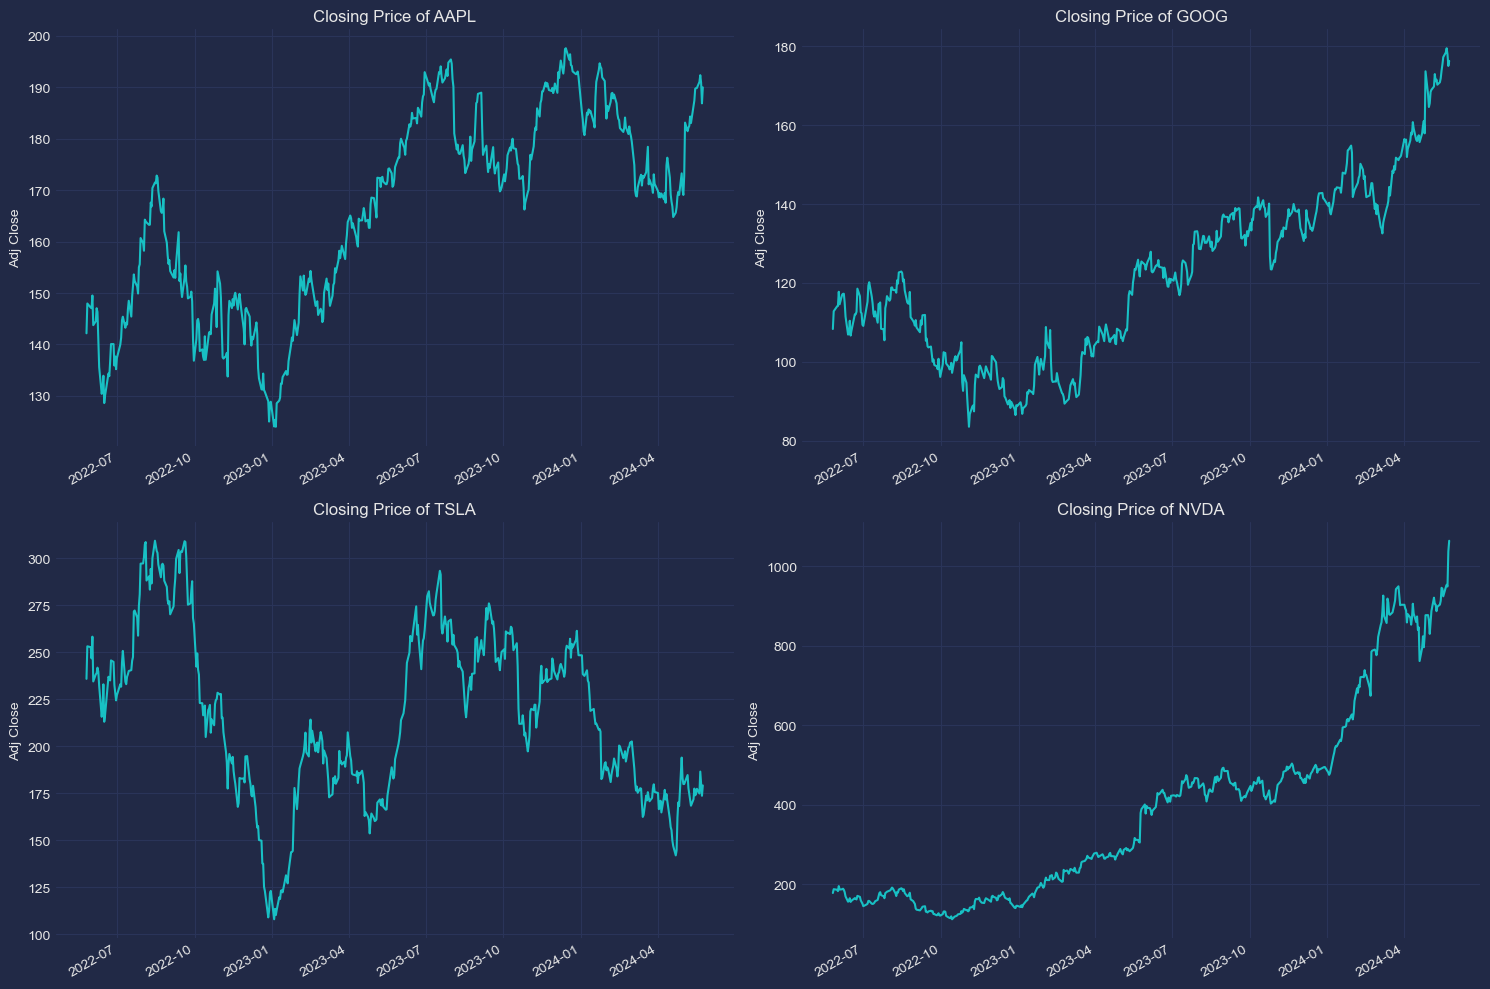

In [3]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stocks_list[i - 1]}")
    plt.grid(True)
    
plt.tight_layout() # Ensures proper spacing between subplots

In [4]:
# Plotting Candlestick chart for Apple stock price

fig = go.Figure(data=[go.Candlestick(x=AAPL.index,
                open=AAPL['Open'],
                high=AAPL['High'],
                low=AAPL['Low'],
                close=AAPL['Close'])])

fig.update_layout(title='Apple Stock Price Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (USD)')

fig.update_layout(template='plotly_dark')

fig.show()

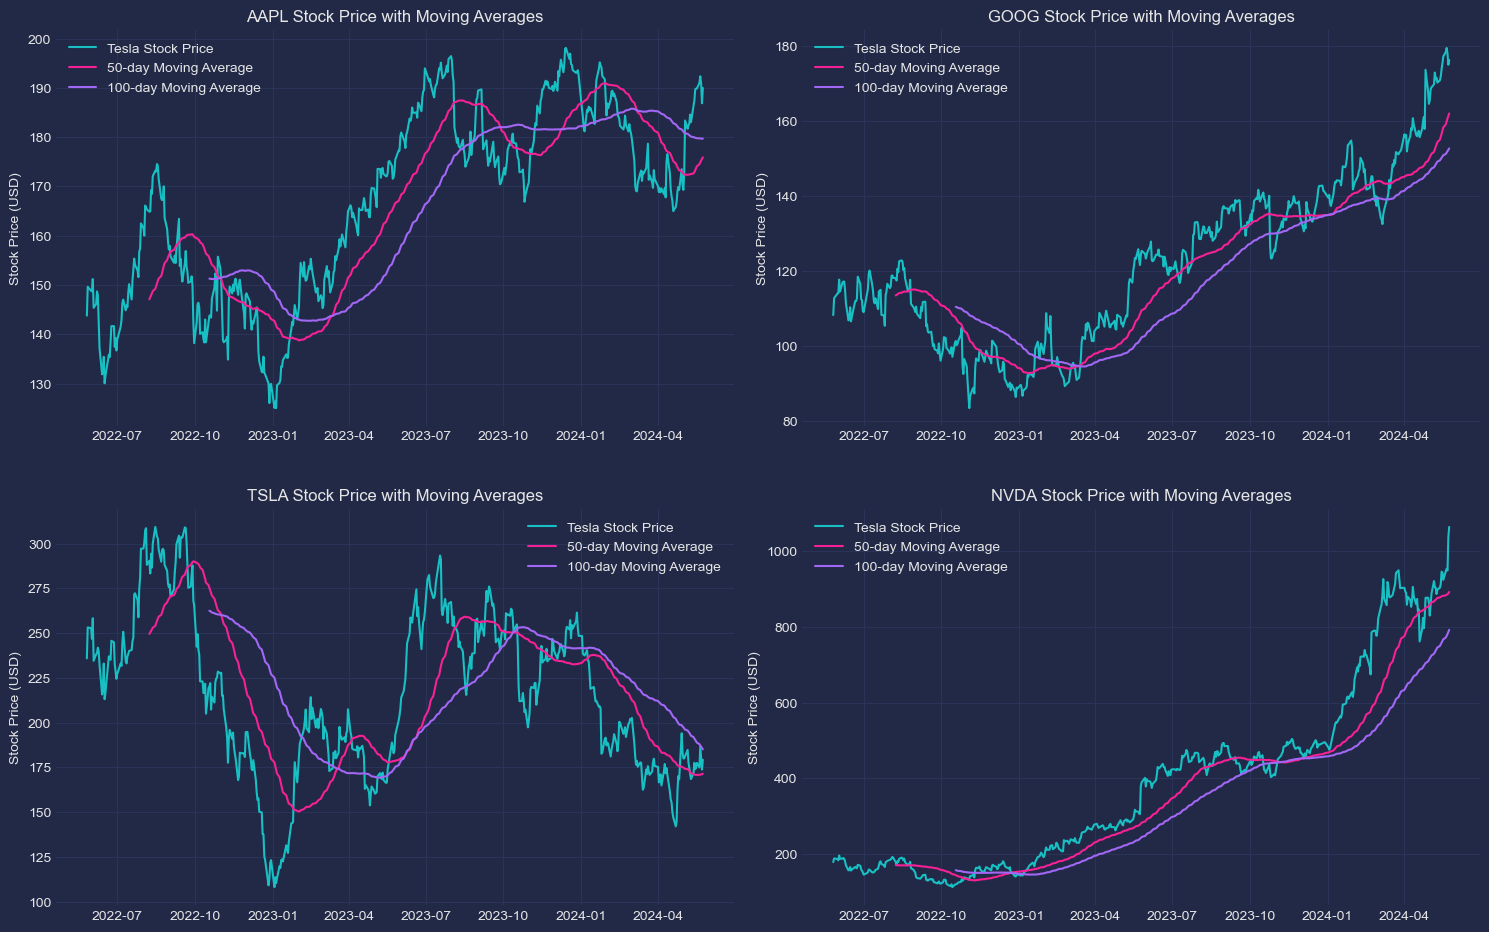

In [5]:
# calculating and plotting MA for each stock
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    
    company['MA50'] = company['Close'].rolling(window=50).mean()
    company['MA100'] = company['Close'].rolling(window=100).mean()
    
    plt.plot(company['Close'], label='Tesla Stock Price')
    plt.plot(company['MA50'], label='50-day Moving Average')
    plt.plot(company['MA100'], label='100-day Moving Average')
    plt.title(f'{stocks_list[i - 1]} Stock Price with Moving Averages')
    plt.xlabel(None)
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# create a new data frame with only 'Close column'
apple_data = AAPL.filter(['Close'])
data = apple_data.values

In [7]:
# Normalization
""" 
Normalization is an important preprocessing step in machine learning, especially for algorithmns that are senstive to the scale of input features. 
It ensures that all features make an equal contribution to the modal training process. Min-Max Scaler and Standard Scaler are two commonly used scalers 
for normalization.

    Min-Max Scaler: this scaler scales the data to a specific range, usually between 0 and 1, it is effective when the data does not have a uniform 
    distribution and is with potential for outliers

    Standard Scaler: Scales the data to have a mean of 0 and a standard deviation of 1. It is less sensitive to outliers because it assumes the data has 
    a Normal distribution
"""

scaler = StandardScaler()

scaled_data = scaler.fit_transform(data)

In [8]:
# Splitting the scaled data into training and testing data
""" 
This line calculates the length of the training data as 80% of the total data. np.ceil() ensures that the number of records in the training set is 
rounded up to the nearest whole number
"""
training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train, y_train datasets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i,0])
    
#convert the x_train and y_train to numppy array and reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(342, 60, 1)

In [9]:
# Building the LSTM model
""" 
The network consists fo a total of 4 layers: three LSTM layers and one dense layer
"""


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=25))
model.add(Dense(units=1))
model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compiling and training the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2097
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0873
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0579
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0459
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0415
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0421
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0339
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0319
Epoch 9/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0303
Epoch 10/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0274
Epoch 11/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0284
Epoch 12/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0218
Epoch 13/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0262
Epoch 14/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0238
Epoch 15/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s

In [11]:
# Preparing test data and making predictions
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = data[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i -60:i, 0])

In [12]:
# convert the data to a numpy array and reshape the data
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [14]:
# Evaluating model performance using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2.671216600721007


In [20]:
test

,Close,Predictions
Date,,
2024-01-03,184.250000,182.979950
2024-01-04,181.910004,183.963501
2024-01-05,181.179993,180.838379
2024-01-08,185.559998,180.796463
2024-01-09,185.139999,185.818619
...,...,...
2024-05-20,191.039993,190.490555
2024-05-21,192.350006,191.650452
2024-05-22,190.899994,192.884766


C:\Users\yanzh\AppData\Local\Temp\ipykernel_16780\3142276586.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



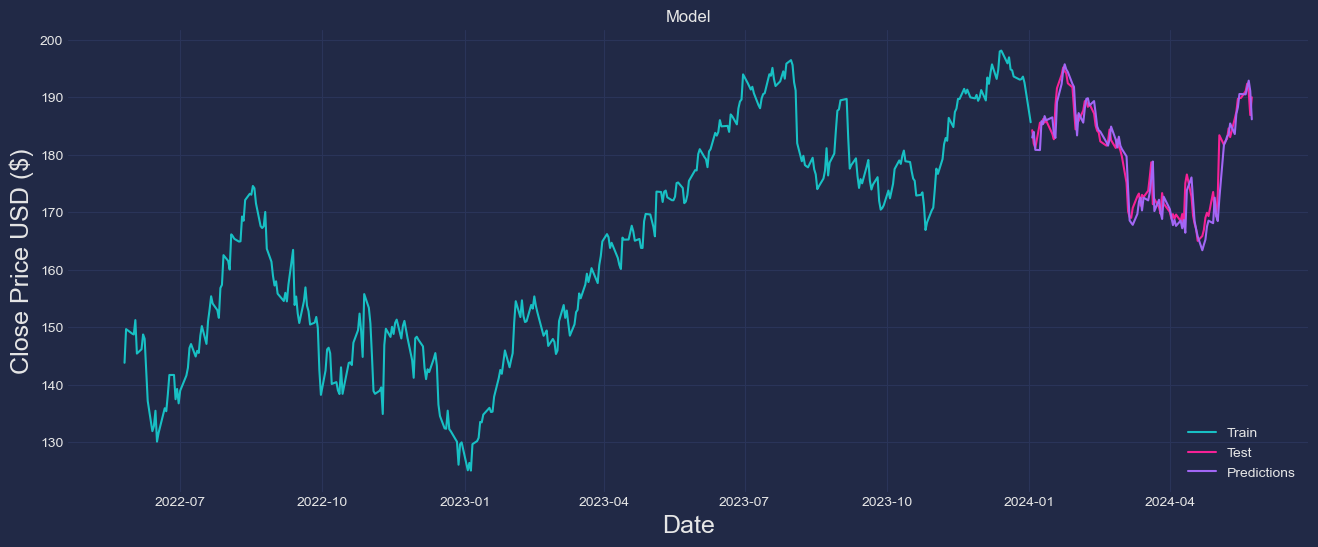

In [15]:
# Plotting the predicted stock prices against actual prices
dataset = apple_data.filter(['Close'])
train = dataset[:training_data_len]
test = dataset[training_data_len:]
test['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()